In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns
import matplotlib
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults

In [3]:
df = pd.read_csv('Data/M2SLMoneyStock.csv',index_col=0,parse_dates=True)
df.index.freq = 'MS'

In [4]:
sp = pd.read_csv('Data/PCEPersonalSpending.csv',index_col=0,parse_dates=True)
sp.index.freq = 'MS'

In [5]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


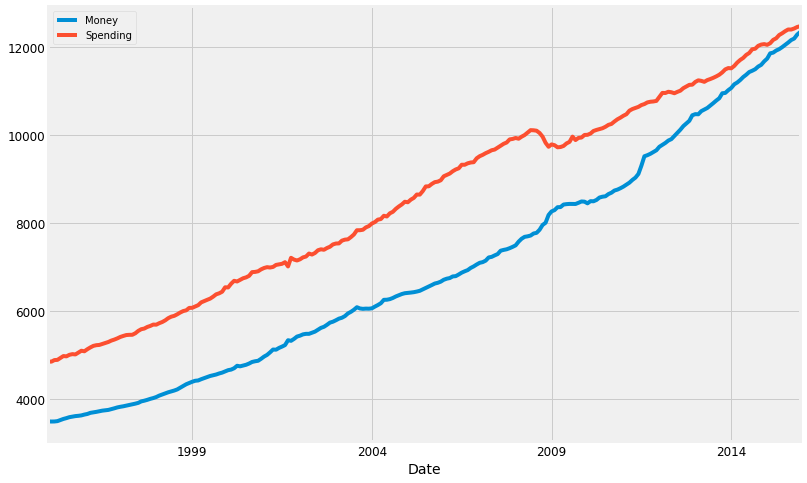

In [6]:
df.plot(figsize = (12,8));

<h3><i><b><u><font color ='red'>test for stationarity and go for any transformations</i></b></u></h3>

In [7]:
adfuller(df['Money'])
# pvalue = 1.0
# so pvalue >0.05 so we fail to reject(accept) null hypothesis so
# Money is non -  stationary

(4.239022425670652,
 1.0,
 4,
 247,
 {'1%': -3.457105309726321,
  '5%': -2.873313676101283,
  '10%': -2.5730443824681606},
 2219.917877142354)

In [8]:
adfuller(df['Spending'])
# pvalue = 0.96
# so pvalue >0.05 so we fail to reject(accept) null hypothesis so
# Spending is non - stationary

(0.1497960859862547,
 0.9693009944428312,
 3,
 248,
 {'1%': -3.4569962781990573,
  '5%': -2.8732659015936024,
  '10%': -2.573018897632674},
 2339.735574840993)

<div class="alert alert-info"><strong>NOTE: </strong> When performing the auto_arima function we're likely to see a <tt><font color=black>ConvergenceWarning: Maximum Likelihood optimization failed to converge.</font></tt> This is not unusual in models which have to estimate a large number of parameters. However, we can override the maximum iterations default of 50, and pass an arbitrarily large number with <tt>maxiter=1000</tt>. We'll see this come up again when we fit our model.</div>  

In [9]:
auto_arima(df['Money'],maxiter = 1000)

ARIMA(maxiter=1000, order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [10]:
auto_arima(df['Spending'],maxiter = 1000)

ARIMA(maxiter=1000, order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

In [11]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [12]:
len(df_transformed)

250

In [13]:
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [14]:
print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


In [15]:
model = VARMAX(train, order=(1,2), trend='c') # constant linear trend
results = model.fit(maxiter=1000, disp=False)
results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.247
,+ intercept,AIC,4606.495
Date:,"Sun, 11 Apr 2021",BIC,4665.524
Time:,17:52:35,HQIC,4630.284
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.32, 0.00",Jarque-Bera (JB):,"562.69, 123.88"
Prob(Q):,"0.57, 0.96",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.68, 2.91",Skew:,"1.34, -0.35"


In [16]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-12.609889,37.473944
2015-02-01,-10.892444,-5.527027
2015-03-01,1.816514,0.004403
2015-04-01,-1.859900,-0.564735
2015-05-01,1.310138,0.338805
2015-06-01,-0.579837,-0.144436
2015-07-01,0.660259,0.183412
2015-08-01,-0.131413,-0.023983
2015-09-01,0.377872,0.109780
2015-10-01,0.050952,0.023977


<h1> Invert the transformation

In [17]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

In [18]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [19]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-12.609889,37.473944,65.990111,11657.490111,48.073944,12099.473944
2015-02-01,-10.892444,-5.527027,55.097667,11646.597667,42.546917,12093.946917
2015-03-01,1.816514,0.004403,56.914181,11648.414181,42.551320,12093.951320
2015-04-01,-1.859900,-0.564735,55.054281,11646.554281,41.986585,12093.386585
2015-05-01,1.310138,0.338805,56.364419,11647.864419,42.325390,12093.725390
2015-06-01,-0.579837,-0.144436,55.784582,11647.284582,42.180954,12093.580954
2015-07-01,0.660259,0.183412,56.444842,11647.944842,42.364366,12093.764366
2015-08-01,-0.131413,-0.023983,56.313429,11647.813429,42.340383,12093.740383
2015-09-01,0.377872,0.109780,56.691301,11648.191301,42.450162,12093.850162
2015-10-01,0.050952,0.023977,56.742254,11648.242254,42.474139,12093.874139


In [20]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11657.490111,12099.473944
2015-02-01,11852.4,12082.4,11646.597667,12093.946917
2015-03-01,11868.8,12158.3,11648.414181,12093.951320
2015-04-01,11916.1,12193.8,11646.554281,12093.386585
2015-05-01,11947.6,12268.1,11647.864419,12093.725390
2015-06-01,11993.1,12308.3,11647.284582,12093.580954
2015-07-01,12045.3,12355.4,11647.944842,12093.764366
2015-08-01,12096.8,12394.0,11647.813429,12093.740383
2015-09-01,12153.8,12392.8,11648.191301,12093.850162


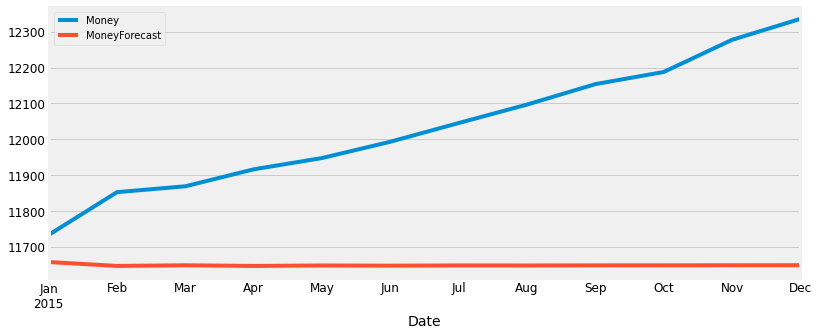

In [21]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

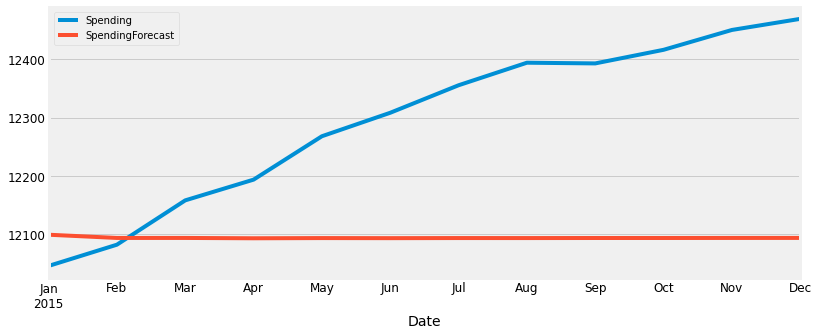

In [22]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

In [23]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 423.549


In [24]:
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 243.769


In [25]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults

In [26]:
model = ARMA(train['Money'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1117.710
Method:                       css-mle   S.D. of innovations             26.214
Date:                Sun, 11 Apr 2021   AIC                           2245.421
Time:                        17:55:07   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1814      0.029      6.302      0.000       0.125       0.238
ar.L1.Money    -0.3569      0.293     -1.217      0.223      -0.931       0.218
ma.L1.Money    -0.4087      0.260     -1.572      0.116      -0.918       0.101
ma.L2.Money    -0.5912      0.260     -2.278      0.023      -1.100      -0.083
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.8023           +0.0000j            2.8023            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.6913           +0.0000j            1.6913            0.5000
-----------------------------------------------------------------------------
"""

In [27]:
start=len(train)
end=len(train)+len(test)-1
z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)

In [28]:
z1

,Money
2015-01-01,-14.499076
2015-02-01,-10.947029
2015-03-01,4.152579
2015-04-01,-1.235722
2015-05-01,0.687095
2015-06-01,0.000937
2015-07-01,0.245793
2015-08-01,0.158416
2015-09-01,0.189596
2015-10-01,0.178470


In [29]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()

In [30]:
z1

,Money,Money1d,MoneyForecast
2015-01-01,-14.499076,64.100924,11734.200924
2015-02-01,-10.947029,53.153895,11787.354819
2015-03-01,4.152579,57.306474,11844.661293
2015-04-01,-1.235722,56.070752,11900.732045
2015-05-01,0.687095,56.757847,11957.489892
2015-06-01,0.000937,56.758784,12014.248676
2015-07-01,0.245793,57.004577,12071.253253
2015-08-01,0.158416,57.162993,12128.416245
2015-09-01,0.189596,57.352589,12185.768834
2015-10-01,0.178470,57.531059,12243.299893


In [31]:
RMSE3 = rmse(df['Money'][-nobs:], z1['MoneyForecast'])

print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE3:.3f}')

Money VARMA(1,2) RMSE: 423.549
Money  ARMA(1,2) RMSE: 32.235


In [32]:
model = ARMA(train['Spending'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1182.411
Method:                       css-mle   S.D. of innovations             34.661
Date:                Sun, 11 Apr 2021   AIC                           2374.823
Time:                        17:56:07   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0856      0.245      0.350      0.726      -0.394       0.565
ar.L1.Spending    -0.3403      0.511     -0.666      0.505      -1.342       0.661
ma.L1.Spending    -0.6451      0.521     -1.237      0.216      -1.667       0.377
ma.L2.Spending    -0.2139      0.485     -0.441      0.659      -1.165       0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9387           +0.0000j            2.9387            0.5000
MA.1            1.1281           +0.0000j            1.1281            0.0000
MA.2           -4.1437           +0.0000j            4.1437            0.5000
-----------------------------------------------------------------------------
"""

In [33]:
start=len(train)
end=len(train)+len(test)-1
z2 = results.predict(start=start, end=end).rename('Spending')
z2 = pd.DataFrame(z2)
z2

,Spending
2015-01-01,33.555785
2015-02-01,-3.338230
2015-03-01,1.250718
2015-04-01,-0.310846
2015-05-01,0.220536
2015-06-01,0.039713
2015-07-01,0.101245
2015-08-01,0.080306
2015-09-01,0.087431
2015-10-01,0.085007


In [34]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()

In [35]:
RMSE4 = rmse(df['Spending'][-nobs:], z2['SpendingForecast'])

print(f'Spending VARMA(1,2) RMSE: {RMSE2:.3f}')
print(f'Spending  ARMA(1,2) RMSE: {RMSE4:.3f}')

Spending VARMA(1,2) RMSE: 243.769
Spending  ARMA(1,2) RMSE: 52.334


<strong>CONCLUSION:</strong> It looks like the VARMA(1,2) model did a relatively poor job compared to simpler alternatives. This tells us that there is little or no interdepence between Money Stock and Personal Consumption Expenditures, at least for the timespan we investigated. This is helpful! By fitting a model and getting poor results we know more about the data than we did before.